In [1]:
import os

os.chdir('/opt/project')
print(os.getcwd())

/opt/project


# ADC Parameters

In [2]:
import os
import json
import pandas as pd
from tqdm import tqdm
import re
from pathlib import Path

def json_to_csv(directory, regex, output_file=None, read_as_string=False):
    """
    Collects all *ADC.json files in the directory and its subdirectories,
    reads their content, and writes to a CSV file.
    
    Parameters:
    directory (str): Path to the directory to search within.
    output_file (str): Path to the output CSV file.
    """
    # Initialize a list to store the data
    data = []

    # Define the regex pattern for file matching
    pattern = re.compile(regex)

    total_files = sum(len(files) for _, _, files in os.walk(directory))
# Initialize tqdm with total number of files
    pbar = tqdm(total=total_files, desc="Processing JSON files")

    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            if pattern.findall(file):
                # Construct the full file path
                file_path = os.path.join(root, file)
                
                # Open and load the JSON file
                with open(file_path, 'r') as json_file:
                    if read_as_string:
                        content = json_file.read().strip()
                        json_data = {'content': content}
                    else:
                        json_data = json.load(json_file)

                    json_data['file_path'] = file_path
                    json_data['patient_id'] = Path(file_path).parent.name
                    data.append(json_data)
                
                # Update progress bar
                pbar.update(1)

    # Close the progress bar
    pbar.close()

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)
    # df.set_index('patient_id', inplace=True)

    # Save the DataFrame to a CSV file
    if output_file is None:
        return df
    
    df.to_csv(output_file, index=False)
    print(f"Data written to {output_file}")

# json_to_csv('./data/Pre-BraTS lists', r'(?i)(_adc|Apparent_Diffusion_Coefficient).*.json$', './data/meningioma_adc.csv')
# json_to_csv('./data/Pre-BraTS lists', r'(?i)(_adc|Apparent_Diffusion_Coefficient).*.bval$', './data/meningioma_bval.csv', read_as_string=True)
# json_to_csv('./data/Pre-BraTS lists', r'(?i)(_t1fs|_t1_fs|_t1_se|_t1se).*.json$', './data/meningioma_t1fs.csv')
# json_to_csv('./data/Pre-BraTS lists', r'(?i)(_t2_tse|_t2_axial|_t2_propeller).*.json$', './data/meningioma_t2.csv')
# json_to_csv('./data/Pre-BraTS lists', r'(?i)(_flair|dark-fluid).*.json$', './data/meningioma_flair.csv')
df = json_to_csv('./data/Pre-BraTS lists', r'.*.json$')





Processing JSON files:  33% 2399/7192 [00:00<00:00, 7592.49it/s]

Processing JSON files:  47% 3410/7192 [00:00<00:00, 7566.95it/s]


# Registration

In [ ]:
import warnings
import pandas as pd
import os
import shutil

# for copying meningioma data from the original folder structure to one suitable with autorad

from multiprocessing import Pool


def process_patient(patient_info):
    patient_src, dest_patient_folder = patient_info
    expected_files = {'ADC.nii.gz', 'flair.nii.gz', 't1.nii.gz', 't1ce.nii.gz', 't2.nii.gz', 'mask.nii.gz'}
    found_files = set()
    for file in os.listdir(patient_src):
        if file.endswith('.nii') or file.endswith('.gz'):
            if 'ADC' in file:
                new_filename = 'ADC.nii'
            elif 'flair' in file:
                new_filename = 'flair.nii.gz'
            elif 't1ce' in file:
                new_filename = 't1ce.nii.gz'
            elif 't1' in file:
                new_filename = 't1.nii.gz'
            elif 't2' in file:
                new_filename = 't2.nii.gz'
            elif '_1.nii' in file or '_2.nii' in file or '_3.nii' in file:
                new_filename = 'mask.nii.gz'
            else:
                warnings.warn(f"Unexpected file {file} in patient folder {patient_src}")
                continue

            src_file_path = os.path.join(patient_src, file)
            dest_file_path = os.path.join(dest_patient_folder, new_filename)
            shutil.copy(src_file_path, dest_file_path)
            print(f"Copied file {src_file_path} to {dest_file_path}")

            found_files.add(new_filename)

    if expected_files != found_files:
        missing_files = expected_files - found_files
        warnings.warn(f"Missing files {missing_files} in patient folder {patient_src}")

    return dest_patient_folder


def copy_patient_data(src_dir, dest_dir, n_cpu=2):
    """
    Copies patient data from the source directory to the destination directory
    while maintaining an ascending pattern of integer-based patient IDs. The function
    creates a mapping of patient IDs, grades, and their original data paths,
    and saves the mapping to a CSV file. It also renames the files as per the required format.

    Parameters:
        src_dir (str): The path to the source directory containing patient data organized by grades.
        dest_dir (str): The path to the destination directory where the copied patient data will be stored.

    Returns:
        None: The function performs the copy operation, file renaming, and saves the mapping to a CSV file.

    Raises:
        FileNotFoundError: If any of the expected files are missing.
        ValueError: If there are additional files that don't match the pattern.
    """
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
    patient_data = []
    patient_info_list = []
    for grade_folder in os.listdir(src_dir):
        grade_path = os.path.join(src_dir, grade_folder)
        if os.path.isdir(grade_path):
            for patient_folder in os.listdir(grade_path):
                patient_src = os.path.join(grade_path, patient_folder)
                if os.path.isdir(patient_src):
                    dest_patient_id = len(os.listdir(dest_dir)) + 1
                    dest_patient_folder = os.path.join(dest_dir, f"ID_{dest_patient_id}")
                    os.makedirs(dest_patient_folder, exist_ok=True)
                    patient_info_list.append((patient_src, dest_patient_folder))
                    grade = 1 if grade_folder == 'Grade1Data' else 2
                    patient_data.append((f"ID_{dest_patient_id}", grade, patient_src))

    # Process patient data in parallel using multiprocessing
    with Pool(n_cpu) as pool:
        dest_patient_folders = pool.map(process_patient, patient_info_list)

    # Create a pandas DataFrame from the patient_data list
    df = pd.DataFrame(patient_data, columns=["Patient_ID", "Grade", "Original_Data_Path"])

    # Save the DataFrame to a CSV file
    df.to_csv("patient_grade_mapping.csv", index=False)


copy_patient_data('./data/meningioma', './data/meningioma_data')

In [ ]:
from src.preprocessing.registration import register_patients

register_patients(data_dir='./data', 
                  static_stem='t1ce.nii.gz',
                    moving_stem='ADC.nii', 
                    utput_stem='registered_adc.nii.gz', 
                    transform_method='rigid')

# Test Autoencoder Performance

In [ ]:
import matploglib.pyplot as plt

def plot_debug(stk_image):
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(stk_image)[5, :, :], cmap='gray')
    plt.show()


def plot_slices(output_tensor, slice_index, num_samples=5, original_tensor=None,
                title=None, save_dir=None):
    """
    Plot a slice from each image modality of the output tensor for a specified number of samples.

    Parameters:
        output_tensor (torch.Tensor): The output tensor from the autoencoder.
        slice_index (int): The index of the slice to be plotted.
        image_modalities (list): List of image modality names.
        num_samples (int): The number of samples to plot.
        title_prefix (str): Prefix to add to the plot titles.

    Returns:
        None
    """
    batch_size, num_modalities, length, width, height = output_tensor.shape
    plt.close('all')

    for sample_idx in range(min(num_samples, batch_size)):
        plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

        for modality_idx in range(num_modalities):
            plt.subplot(2, num_modalities, modality_idx + 1)
            plt.imshow(output_tensor[sample_idx, modality_idx, slice_index, :, :], cmap='gray')
            plt.title(f'generated Sample {sample_idx + 1}, {modality_idx}')
            plt.axis('off')

        if original_tensor is not None:
            for modality_idx in range(num_modalities):
                plt.subplot(2, num_modalities, num_modalities + modality_idx + 1)
                plt.imshow(original_tensor[sample_idx, modality_idx, slice_index, :, :], cmap='gray')
                plt.title(f'original Sample {sample_idx + 1}, {modality_idx}')
                plt.axis('off')

        if title is not None:
            plt.suptitle(title)
        if save_dir is not None:
            plt.savefig(save_dir+f'_{sample_idx}.png')

        plt.show()                                   

In [ ]:
import torch
from src.dataset.visualisation import plot_slices
from src.pipeline.pipeline_components import get_multimodal_feature_dataset
import pandas as pd
import numpy as np
import torchio as tio
from skorch.callbacks import EarlyStopping, GradientNormClipping, ParamMapper, PassthroughScoring, LRScheduler
from src.dataset import TransformingDataLoader, SkorchSubjectsDataset
from sklearn.model_selection import ParameterGrid
from src.models import BetaVAELoss, NeuralNetEncoder, FMCIBModel, Med3DEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, get_scorer, recall_score, precision_score
from src.metrics import roc_auc
import skorch
import optuna
from datetime import datetime
import os
import logging
from torch.optim.lr_scheduler import StepLR
# logging.basicConfig(level=logging.DEBUG)

# setup dataset, extract features, split the data
feature_dataset = get_multimodal_feature_dataset(data_dir='./data/meningioma_data',
                                                 image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                                                 mask_stem='mask',
                                                 target_column='Grade',
                                                 label_csv_path='./data/meningioma_meta.csv',
                                                 extraction_params='./conf/radiomic_params/meningioma_mr.yaml',
                                                 feature_df_merger={
                                                     '_target_': 'src.pipeline.df_mergers.meningioma_df_merger'},
                                                 n_jobs=6,
                                                 existing_feature_df='tests/meningioma_feature_dataset.csv',
                                                 additional_features=['ID']
                                                 )

id_list = feature_dataset.X['ID'].to_numpy()

dataset_train_transform = tio.Compose([tio.Resample((1, 1, 1)),
                                                    tio.ToCanonical(),
                                                    tio.Mask(masking_method='mask', outside_value=0),
                                                    tio.CropOrPad(target_shape=(88, 88, 88), mask_name='mask'),
                                                    tio.Resize(target_shape=(50,50,50)),
                                                    # tio.RescaleIntensity(masking_method='mask'),
                                                    tio.ZNormalization(masking_method='mask'),
                                                    ])
encoder_kwargs = dict(module=FMCIBModel,
                    module__input_channels=5,
                    module__weights_path='outputs/pretrained_models/model_weights.torch',
                    module__output_class=2,
                    module__latent_var_dim=2048,
                    batch_size=5,
                    # output_format='pandas',
                    max_epochs=200,
                    callbacks=[EarlyStopping(load_best=True),
                               GradientNormClipping(1),

                               ],
                    # optimizer='torch.optim.AdamW',
                    optimizer='torch.optim.Adam',
                    lr=0.0001,
                    iterator_train=TransformingDataLoader,
                    iterator_train__augment_transforms=tio.Compose([tio.RandomGamma(log_gamma=0.1, label_keys=('mask',)),
                                                                    tio.RandomAffine(p=0.5, label_keys=('mask',),
                                                                                     scales=0.1, degrees=90,
                                                                                     translation=10, isotropic=True),
                                                                    tio.RandomFlip(flip_probability=0.5,
                                                                                   label_keys=('mask',), axes=(0, 1, 2))
                                                                    ]),
                    iterator_train__num_workers=10,
                    iterator_valid__num_workers=4,
                    dataset=SkorchSubjectsDataset,
                    dataset__transform=dataset_train_transform,
                    dataset__data_dir='./data/meningioma_data',
                    dataset__image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                    dataset__mask_stem='mask',
                    device='cuda',
                    criterion="torch.nn.BCELoss",
                    criterion__weight=torch.tensor([0.016,0.09]),
                    weighted_sampler=True,

                    )



def recall(y_true, y_pred, **kwargs):
    if len(y_true.shape) >= 2: #if given in n_sample x n_class format
        if y_true.shape[1] == 2: #if it's binary case
            y_true = y_true[:, 1]
        elif y_true.shape[1] == 1: #if it's binary case
            y_true = y_true[:, 0]
    if len(y_pred.shape) >= 2: #if given in n_sample x n_class format
        if y_pred.shape[1] == 2: #if it's binary case
            y_pred = y_pred[:, 1]
        elif y_pred.shape[1] == 1: #if it's binary case
            y_pred = y_pred[:, 0]

    return recall_score(y_true, y_pred, **kwargs)

def precision(y_true, y_pred, **kwargs):
    if len(y_true.shape) >= 2: #if given in n_sample x n_class format
        if y_true.shape[1] == 2: #if it's binary case
            y_true = y_true[:, 1]
        elif y_true.shape[1] == 1: #if it's binary case
            y_true = y_true[:, 0]

    if len(y_pred.shape) >= 2: #if given in n_sample x n_class format
        if y_pred.shape[1] == 2: #if it's binary case
            y_pred = y_pred[:, 1]
        elif y_pred.shape[1] == 1: #if it's binary case
            y_pred = y_pred[:, 0]
    return precision_score(y_true, y_pred, **kwargs)

encoder = NeuralNetEncoder(**encoder_kwargs)
roc_auc_scorer = make_scorer(roc_auc, needs_proba=True)

scores = cross_validate(encoder, id_list, feature_dataset.y.to_numpy(), cv=5, scoring={'roc_auc':roc_auc_scorer,'precision':make_scorer(precision),'recall':make_scorer(recall)}, error_score='raise', verbose=3)

print(f"Mean roc_auc: {np.mean(scores['test_roc_auc'])} std roc_auc: {np.std(scores['test_roc_auc'])}")
print(f"Mean precision: {np.mean(scores['test_precision'])} std precision: {np.std(scores['test_precision'])}")
print(f"Mean recall: {np.mean(scores['test_recall'])} std recall: {np.std(scores['test_recall'])}")



def objective(trial):
    lr_ = trial.suggest_float('lr', 1e-6,1e-2,log=True)

    parameters = {'lr': lr_}
    encoder_kwargs.update(parameters)

    encoder = NeuralNetEncoder(**encoder_kwargs)
    # Perform cross-validation with the current parameters
    roc_auc_scorer = make_scorer(roc_auc, needs_proba=True)
    scores = cross_val_score(encoder, id_list, feature_dataset.y.to_numpy(), cv=5, scoring=roc_auc_scorer)

    # Return the mean of cross-validation scores as the objective value
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f"Best score: {study.best_value}")
print(f"Best params: {study.best_params}")

output_dir = f"outputs/dl_tests/{datetime.now().strftime('%Y%m%d%H%M%S')}"
os.makedirs(output_dir, exist_ok=True)

study.trials_dataframe().to_csv(os.path.join(output_dir, "study_df.csv"))

# Find Optimal shape of Encoder to crop to

In [166]:
from src.pipeline.pipeline_components import get_multimodal_feature_dataset
from src.dataset.skorch_subject_ds import SkorchSubjectsDataset
import torchio as tio
import numpy as np


feature_dataset = get_multimodal_feature_dataset(data_dir='./data/meningioma_data',
                                                 image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                                                 mask_stem='mask',
                                                 target_column='Grade',
                                                 label_csv_path='./data/meningioma_meta.csv',
                                                 extraction_params='./conf/radiomic_params/meningioma_mr.yaml',
                                                 feature_df_merger={
                                                     '_target_': 'src.pipeline.df_mergers.meningioma_df_merger'},
                                                 n_jobs=6,
                                                 existing_feature_df='tests/meningioma_feature_dataset.csv',
                                                 additional_features=['ID']
                                                 )

ds = SkorchSubjectsDataset(feature_dataset.X.ID, None, data_dir='./data/meningioma_data',
                           image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                           mask_stem='mask',
                           transform=tio.Compose([tio.Resample(target=1),tio.ToCanonical(),tio.CropOrPad(target_shape=None, mask_name='mask')]))

shapes = [ds[i][0].shape for i in range(len(ds))]

np_shapes = np.concatenate(shapes)

np.unique(np_shapes, return_counts=True)

(array([ 5, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
        63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 81, 82, 87,
        88]),
 array([115,   1,   1,   4,   5,   2,   6,   1,   7,  10,   7,  11,   5,
          9,  12,   9,   4,   8,   8,   4,   7,   7,   7,   6,   8,   4,
          8,   7,   8,   8,   7,  12,  12,   3,  12,   5,   2,   9,   2,
          8,   9,   7,   2,   9,   4,   6,   6,   5,   3,   2,   6,   6,
          2,   1,   3,   1,   3,   1,   1,   2,   1,   1,   1,   1,   1,
          2,   1,   1,   1]))

# Explainer

In [26]:
import mlflow
from autorad.models.classifier import MLClassifier
from autorad.inference import infer_utils
import shap
from src.analysis.shap import get_shap_values, plot_shap_bar, summate_shap_bar
import matplotlib.pyplot as plt

model1_run_id = '2e81644f243e4d4d84c692e8653a2667' #radiomics only
model2_run_id = '60e74372c5844fd0aa28bddefc58acd9' #radiomics and deep learning

# model1_output_dir = 'outputs/meningioma/2024-01-06-00-08-33'
# model2_output_dir = 'outputs/meningioma+autoencoder/2024-01-06-01-06-13'




In [27]:
model1_shap_values, dataset_df, dataset_splits = get_shap_values(model1_run_id)
# model2_shap_values, _, _ = get_shap_values(model2_run_id, dataset_df, dataset_splits)

27055.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
27056.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
27056.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/opt/conda/lib/python3.10/site-packages/debugpy/_vendored/force_pydevd.py:18: UserWarning: incompatible copy of pydevd already imported:
 /opt/conda/lib/python3.10/site-packages/pydevd_plugins/extensions/pydevd_plugin_omegaconf.py
  warnings.warn(msg + ':\n {}'.format('\n  '.join(_unvendored)))
27056.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
27056.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/opt/conda/lib/python3.10/site-packages/debugpy/_vendored/force_pydevd.py:18: UserWarning: incompatible copy of pydevd already imported:
 /opt/conda/lib/python3.10/site-packages/pydevd_plugins/extensions/pydevd_plugin_omegac

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/dependence_plot.png/dependence_plot_feature.png'

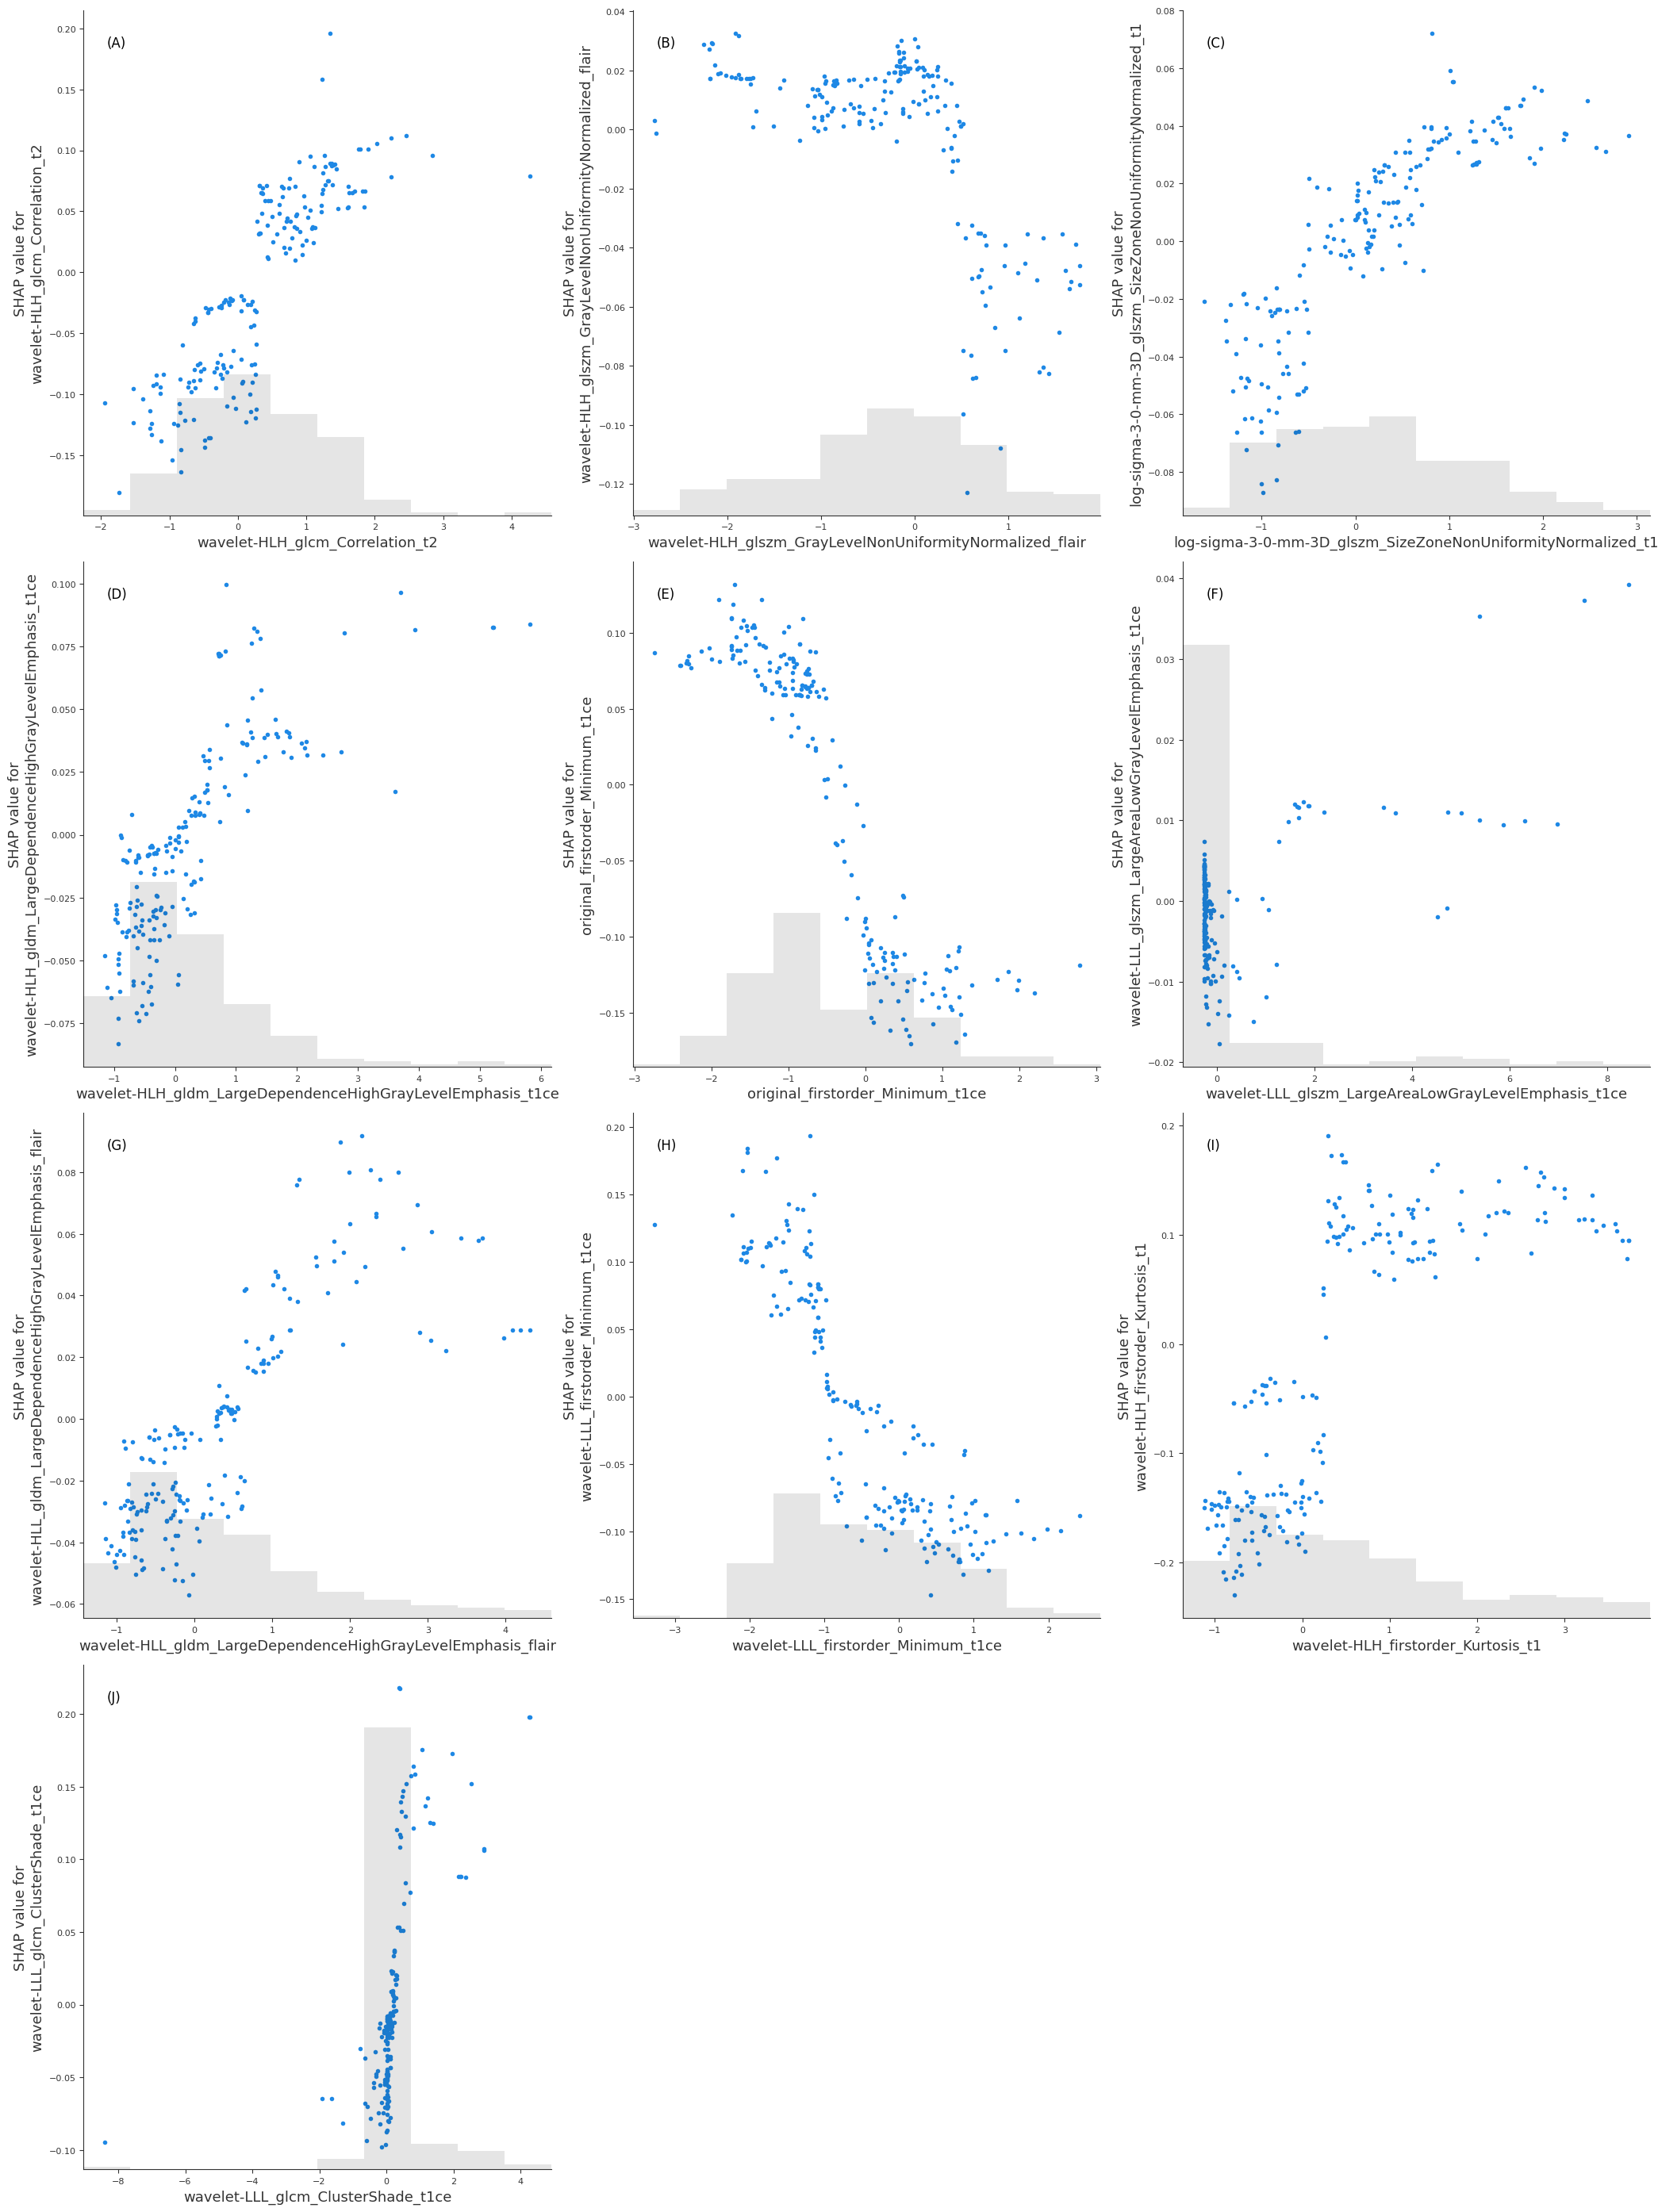

In [31]:
import string

def plot_dependence_scatter_plot(shap_values, n_features, save_dir=None, plots_per_row=3):
    top_features_indices = np.mean(np.abs(shap_values.values), 0).argsort()
    n_features = min(n_features, len(top_features_indices))

    plots_per_row_ = min(plots_per_row, n_features)
    num_rows = (n_features - 1) // plots_per_row_ + 1

    fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row_, figsize=(7*plots_per_row, 7*num_rows))

    letters = iter(string.ascii_uppercase)

    for idx in range(len(axes.flatten())):
        row = idx // plots_per_row_
        col_idx = idx % plots_per_row_

        if len(axes.shape)==2:
            selected_ax = axes[row, col_idx]
        elif len(axes.shape)==1:
            selected_ax = axes[col_idx]
        
        if idx >= n_features:
            fig.delaxes(selected_ax)
            continue
    
        shap.plots.scatter(shap_values[:, np.where(top_features_indices==idx)[0][0]], ax=selected_ax, show=False)

        for label in (selected_ax.get_xticklabels() + selected_ax.get_yticklabels()): 
            label.set_fontsize(8)

        letter = next(letters)
        selected_ax.text(0.05, 0.95, f"({letter})", transform=selected_ax.transAxes, fontsize=12, va='top', ha='left')
    
    plt.tight_layout()

    if save_dir is not None:
        fig.savefig(f"{save_dir}/dependence_plot_feature.png", dpi=1200)
    else:
        plt.show()
    plt.close('all')

plot_dependence_scatter_plot(model1_shap_values, 12, save_dir='outputs/')

# Other code:

In [14]:
from datetime import datetime

def find_time_difference(time1, time2, format='%Y-%m-%d %H:%M:%S,%f'):

    date1 = datetime.strptime(time1, format)
    date2 = datetime.strptime(time2, format)
    difference = date2-date1
    return difference

find_time_difference('2024-04-27 02:25:10,102', '2024-04-27 02:29:01,149')/500

datetime.timedelta(microseconds=462094)

In [5]:
import pingouin as pg
from autorad.feature_selection.selector import CoreSelector
import pandas as pd
import numpy as np
from collections import defaultdict



class ICCSelector(CoreSelector):
    def __init__(self, icc_type='ICC2', icc_threshold=0.6):
        self.icc_type = icc_type
        self.icc_threshold = icc_threshold
        super().__init__()

    def fit(self, X, y):
        iccs = get_feature_icc(X, y, self.icc_type)
        selected_columns = np.where(iccs['ICC'].to_numpy()>self.icc_threshold)[0]
        self._selected_features = X.columns[selected_columns].to_list()

def get_feature_icc(X: pd.DataFrame, y: pd.Series, icc_type='ICC2'):
    #judges are y
    #wine is feature names
    #score is the value of the feature name

    icc_results = []
    for feature_name in X.columns:
        feature_name_col = generate_feature_name_col(y)
        combined_df = pd.concat([feature_name_col, y, X[feature_name]], axis=1)
        icc_result = pg.intraclass_corr(data=combined_df, targets='Feature Name',raters=y.name, ratings=feature_name, nan_policy='omit')
        icc_result = icc_result.set_index('Type')
        icc_results.append({'Feature Name': feature_name,'ICC':icc_result.loc[icc_type, 'ICC']})
    return pd.DataFrame(icc_results)

def generate_feature_name_col(y):
    seen_counts = defaultdict(int)
    feature_names=[]
    for value in y.to_list():
        feature_names.append(seen_counts[value])
        seen_counts[value] +=1

    return pd.Series(feature_names, name='Feature Name')

is mapping
is mapping
is string


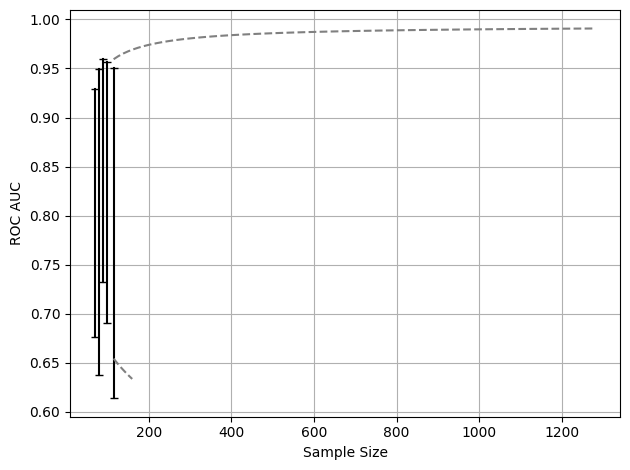

In [112]:
sample_size_dir_list = ['outputs/sample_size_calculation/2024-02-27-06-45-22/sample_size_115.pkl',
                   'outputs/sample_size_calculation/2024-02-27-06-45-22/sample_size_100.pkl',
                   'outputs/sample_size_calculation/2024-02-29-05-18-45/sample_size_90.pkl',
                   'outputs/sample_size_calculation/2024-02-29-05-18-45/sample_size_80.pkl',
                   'outputs/sample_size_calculation/2024-02-29-05-18-45/sample_size_70.pkl']

import pickle

from src.pipeline.sample_size import plot_confidence_intervals

confidence_intervals = []

for sample_size_dir in sample_size_dir_list:
    with open(sample_size_dir, 'rb') as f:
        confidence_intervals.append(pickle.load(f)['roc_auc'])

sample_sizes = [115, 100, 90, 80, 70]

plot_confidence_intervals(sample_sizes, confidence_intervals, 'ROC AUC', save_dir='outputs/sample_size_calculation/2024-02-29-05-18-45/sample_size_calculation.png')

In [21]:
import joblib
from sklearn.ensemble import RandomForestClassifier

# Define the file path
file_path = "outputs/meningioma/2024-04-28-06-12-09/preprocessed.pkl"

# Load the file using joblib
preprocessed_data = joblib.load(file_path)

for feature_selector, selected_data in preprocessed_data[0].items():
    for oversamplor, sampled_data in selected_data.items():
        for (X_train,y_train,_,X_val,y_val,_,) in sampled_data.iter_training():
            X_train = X_train.to_numpy(np.float32)
            y_train = y_train.to_numpy()
            X_val = X_val.to_numpy(np.float32)
            y_val = y_val.to_numpy()

            clf = RandomForestClassifier()
            clf.fit(X_train, y_train)

            y_pred_proba = clf.predict_proba(X_val)

            # print(X_train.shape)
            # print(y_train.shape)
            # print(X_val.shape)
            # print(y_val.shape)

In [24]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts()

[]

# Generate Icons

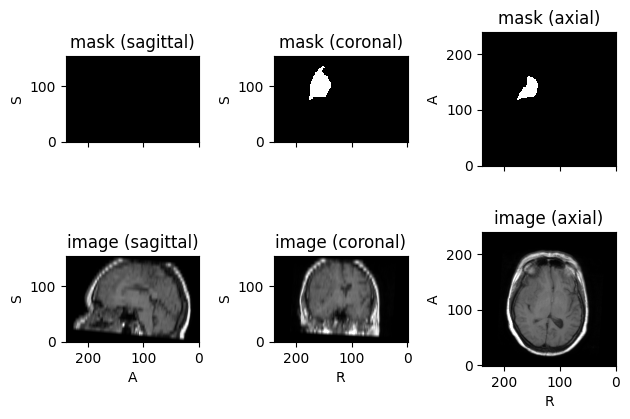

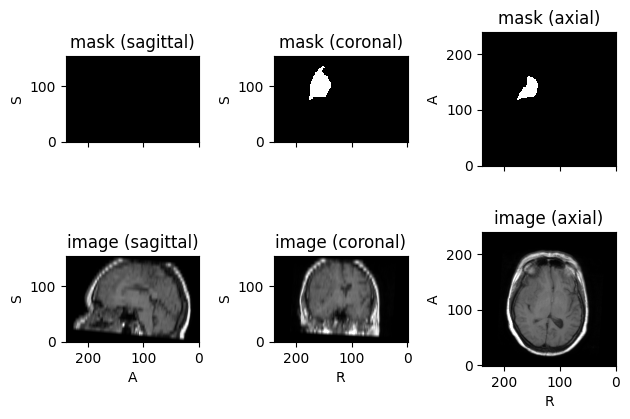

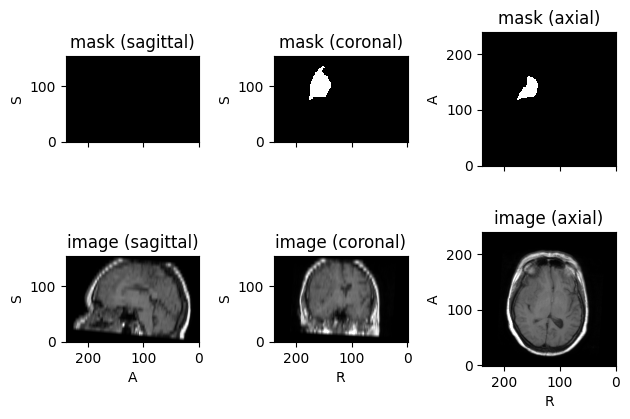

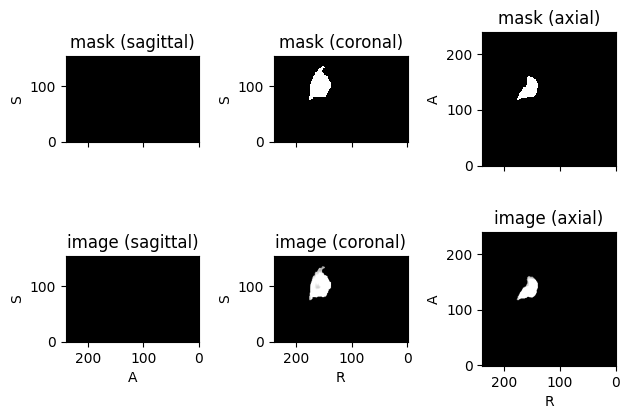

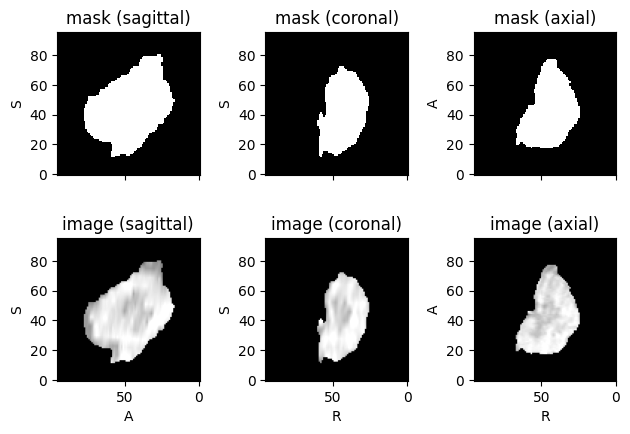

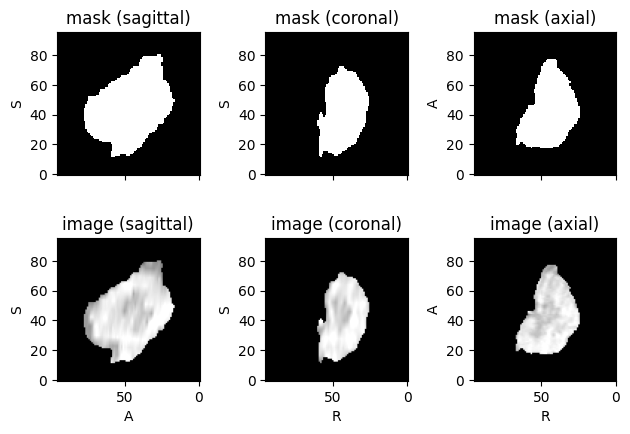

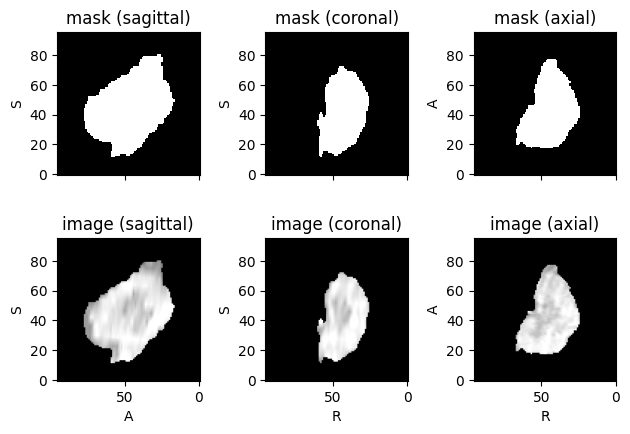

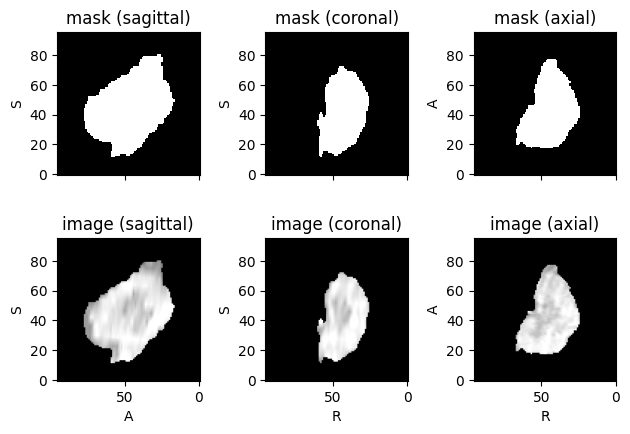

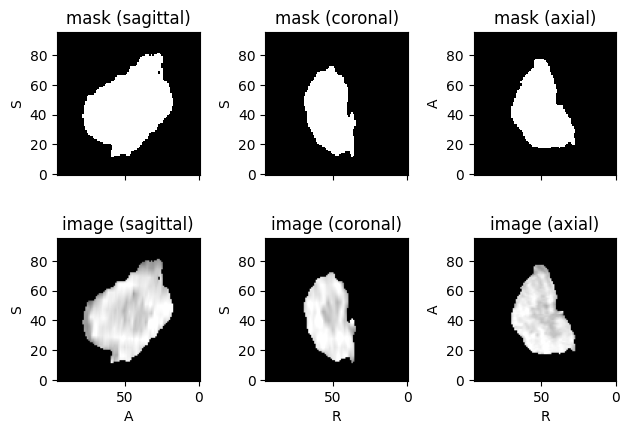

In [75]:
from src.pipeline.pipeline_components import get_data
from autorad.visualization import plot_volumes
import matplotlib.pyplot as plt
import torchio as tio

image_dataset = get_data('./data/meningioma_data', 't1', 'mask')


class Demonstrator:
    def __init__(self, image_dataset, n: int = 1, label:int=1):
        self.image_dataset = image_dataset
        self.case = image_dataset.df.iloc[n]
        self.label = label
    
    def plot_segmented(self):
        image_2D, mask_2D = self.get_2d_image()
        single_plot = plot_volumes.overlay_mask_contour(image_2D, mask_2D)
        fig, axs = plt.subplots(1, 1)
        axs.imshow(single_plot, cmap='gray')
        # axs.set_title(f"{case[image_dataset.ID_colname]}")
        axs.axis("off")
        plt.show()

    def plot_original(self):
        image_2D, mask_2D = self.get_2d_image()
        _, axs = plt.subplots(1,1)
        plt.imshow(image_2D, cmap='gray')
        axs.axis("off")

        plt.show()

    def get_2d_image(self):
        vols = plot_volumes.BaseVolumes.from_nifti(
        self.case[self.image_dataset.image_colname],
        self.case[self.image_dataset.mask_colname],
        window=None,
        label=self.label
        )
        image_2D, mask_2D = vols.get_slices()
        return image_2D, mask_2D

    def plot_transforms(self, transforms):
        tio_subject = tio.Subject(mask=tio.LabelMap(self.case[self.image_dataset.mask_colname]),
                                image=tio.ScalarImage(self.case[self.image_dataset.image_colname]))

        tio_subject.plot()
        for transform in transforms:
            tio_subject = transform(tio_subject)
            tio_subject.plot()


demonstrator = Demonstrator(image_dataset, 10)
# demonstrator.plot_segmented()
# demonstrator.plot_original()
demonstrator.plot_transforms([tio.Resample((1, 1, 1)),
                                tio.ToCanonical(),
                                tio.Mask(masking_method='mask', outside_value=0),
                                tio.CropOrPad(target_shape=(96, 96, 96), mask_name='mask'),
                                tio.ZNormalization(masking_method='mask'),
                                tio.RandomGamma(log_gamma=0.1, label_keys='mask'),
                                tio.RandomAffine(p=0.5, label_keys='mask',
                                                    scales=0.1, degrees=0,
                                                    translation=0, isotropic=True),
                                tio.RandomFlip(flip_probability=0.5,
                                                label_keys='mask', axes=(0, 1, 2))])

(26, 192, 192)


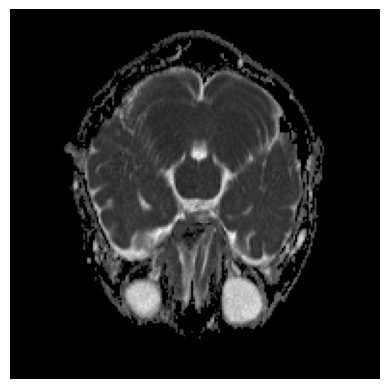

(155, 240, 240)


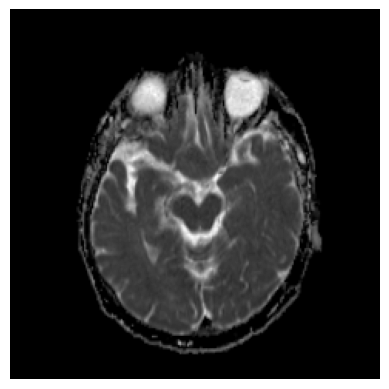

In [61]:
import SimpleITK as sitk

def plot_nifti(path, index):
    image = sitk.ReadImage(path)
    fig, ax = plt.subplots(1,1)
    print(sitk.GetArrayFromImage(image).shape)
    plt.imshow(sitk.GetArrayFromImage(image)[index,:,:], cmap="gray")
    ax.axis('off')
    plt.show()

plot_nifti('data/meningioma_data/ID_1/ADC.nii', 8)

plot_nifti('data/meningioma_data/ID_1/registered_adc.nii.gz', 60)

# Transfer Learning

In [177]:
from src.models.autoencoder.med3d_resnet import med3d_resnet10

restnet10 = med3d_resnet10(sample_input_W=96, sample_input_H=96, sample_input_D=96, shortcut_type='B', num_seg_classes=2)
restnet10



ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, 

In [2]:
import importlib
importlib.reload(importlib.import_module("src.models.autoencoder.med3d_resnet"))
importlib.reload(importlib.import_module("src.models.autoencoder.segresnet"))
from src.models.autoencoder import Med3DEncoder
import torch
import re
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

restnet50 = Med3DEncoder(block='Bottleneck', blocks_down=[3,4,6,3],input_image_size=[96,96,96], shortcut_type='B', in_channels=5,
                        #    pretrained_param_path='outputs/pretrained_models/resnet_10_23dataset.pth'
                           )



restnet50
# load_pretrained_params(restnet10,'outputs/pretrained_models/resnet_10_23dataset.pth')


# restnet10.state_dict().keys()

Med3DEncoder(
  (act_mod): ReLU(inplace=True)
  (convInit): Sequential(
    (conv1): Conv3d(5, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (down_layers): Sequential(
    (down_max_pool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1,

In [1]:
import torch

def inspect_params():

    pretrained_weights = torch.load('outputs/pretrained_models/resnet_50_23dataset.pth', 'cpu')['state_dict']
    # restnet10.to('cpu')
    # print(restnet10.state_dict()['down_layers.layer1.0.conv1.weight'].cpu() == pretrained_weights['module.layer1.0.conv1.weight'].cpu())
    # print(pretrained_weights['module.layer1.0.conv1.weight'].get_device())
    for k, v in pretrained_weights.items():
        print(f"{k}: {v.shape}")

inspect_params()

module.conv1.weight: torch.Size([64, 1, 7, 7, 7])
module.bn1.weight: torch.Size([64])
module.bn1.bias: torch.Size([64])
module.bn1.running_mean: torch.Size([64])
module.bn1.running_var: torch.Size([64])
module.bn1.num_batches_tracked: torch.Size([])
module.layer1.0.conv1.weight: torch.Size([64, 64, 1, 1, 1])
module.layer1.0.bn1.weight: torch.Size([64])
module.layer1.0.bn1.bias: torch.Size([64])
module.layer1.0.bn1.running_mean: torch.Size([64])
module.layer1.0.bn1.running_var: torch.Size([64])
module.layer1.0.bn1.num_batches_tracked: torch.Size([])
module.layer1.0.conv2.weight: torch.Size([64, 64, 3, 3, 3])
module.layer1.0.bn2.weight: torch.Size([64])
module.layer1.0.bn2.bias: torch.Size([64])
module.layer1.0.bn2.running_mean: torch.Size([64])
module.layer1.0.bn2.running_var: torch.Size([64])
module.layer1.0.bn2.num_batches_tracked: torch.Size([])
module.layer1.0.conv3.weight: torch.Size([256, 64, 1, 1, 1])
module.layer1.0.bn3.weight: torch.Size([256])
module.layer1.0.bn3.bias: torch.S